In [ ]:
import torch
import torch.nn as nn

seed = 1
torch.manual_seed(seed)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split


from torch.utils.data import Dataset, DataLoader

### Read Dataset

In [22]:
data = pd.read_csv('/kaggle/input/aiomodule6weather-forecast/dataset/weatherHistory.csv')
data.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


In [23]:
data_final = data.select_dtypes(float)
data_final = data_final.drop(columns = ['Apparent Temperature (C)'])
data_final.head()
columns = data_final.columns

### Split data, preprocessing

In [24]:
from sklearn.model_selection import train_test_split
X = data_final
y = data_final[['Temperature (C)']]
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2, random_state = 42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, shuffle = True, test_size = 0.25, random_state = 42)
X_train.shape, X_test.shape, X_val.shape, type(X_train)

((57871, 7), (19291, 7), (19291, 7), pandas.core.frame.DataFrame)

In [25]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.values)
X_test = scaler.transform(X_test.values)
X_val = scaler.transform(X_val.values)

X_train = pd.DataFrame(X_train, columns = columns)
X_test = pd.DataFrame(X_test, columns = columns)
X_val = pd.DataFrame(X_val, columns = columns)
X_train.shape, X_test.shape, X_val.shape, type(X_train)

((57871, 7), (19291, 7), (19291, 7), pandas.core.frame.DataFrame)

### Create Sequence From Dataset

In [26]:
def create_sequences(df, lag, ahead):
    features = []
    labels = []

    for i in range(len(df) -lag -ahead +1):
        feature = df.values[i:(i+lag)]
        label = df["Temperature (C)"].values[(i+lag):(i+lag+ahead)]

        features.append(feature)
        labels.append(label)

    return np.array(features), np.array(labels).squeeze()

X_train, y_train = create_sequences(X_train, 6, 1)
X_test, y_test = create_sequences(X_test, 6, 1)
X_val, y_val = create_sequences(X_val, 6, 1)
X_train.shape, y_train.shape

((57865, 6, 7), (57865,))

### Split dataset

In [214]:
# val_size = 0.2
# test_size = 0.125
# is_shuffle = False

# features = X.tolist()
# targets = y.tolist()

# X_train, X_val, y_train, y_val = train_test_split(
#     features, targets,
#     test_size=val_size,
#     random_state=seed,
#     shuffle=is_shuffle
# )

# X_train, X_test, y_train, y_test = train_test_split(
#     X_train, y_train,
#     test_size=test_size,
#     random_state=seed,
#     shuffle=is_shuffle
# )

### Pytorch Dataset

In [27]:
import torch
from torch.utils.data import Dataset

class WeatherForecast(Dataset):
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        features = self.features[idx]
        targets = self.targets[idx]

        return torch.tensor(features, dtype = torch.float32), torch.tensor(targets, dtype = torch.float32)

In [28]:
train_dataset = WeatherForecast(
    X_train, 
    y_train,
)

val_dataset = WeatherForecast(
    X_val, 
    y_val,
)

test_dataset = WeatherForecast(
    X_test, 
    y_test,
)

In [29]:
sample_id = 2

# Check 0-th sample and dataset length
text0, label0 = train_dataset[sample_id]
print(f"Train 0-th sample - text shape: {text0.shape}, label: {label0}")
print(f"Train dataset length: {len(train_dataset)}")

text0_val, label0_val = val_dataset[sample_id]
print(f"Val 0-th sample - text shape: {text0_val.shape}, label: {label0_val}")
print(f"Val dataset length: {len(val_dataset)}")

text0_test, label0_test = test_dataset[sample_id]
print(f"Test 0-th sample - text shape: {text0_test.shape}, label: {label0_test}")
print(f"Test dataset length: {len(test_dataset)}")


Train 0-th sample - text shape: torch.Size([6, 7]), label: -1.2459574937820435
Train dataset length: 57865
Val 0-th sample - text shape: torch.Size([6, 7]), label: 1.1324974298477173
Val dataset length: 19285
Test 0-th sample - text shape: torch.Size([6, 7]), label: -0.2173106074333191
Test dataset length: 19285


### Data Loader

In [30]:
test_batch_size = 64
train_batch_size = 128

train_loader = DataLoader(
    train_dataset,
    batch_size=train_batch_size,
    shuffle=False,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

test_loader = DataLoader(
    test_dataset,
    batch_size=test_batch_size,
    shuffle=False,
)

### Build Transformer Model

In [31]:
import torch
import torch.nn as nn
import math

class input_embeding(nn.Module):
    def __init__(self, d_model, max_length = 6):
        super().__init__()
        self.feature_emb = nn.Linear(7, d_model)
        self.dropout = nn.Dropout(0.5)
        self.pos_emb = nn.Embedding(num_embeddings=max_length, embedding_dim=d_model)

    def positional_encoding(self, seq_len, d_model, device):
        position = torch.arange(seq_len, device=device).unsqueeze(1).float()
        div_term = torch.exp(torch.arange(0, d_model, 2, device=device).float() *
                             -(math.log(10000.0) / d_model))
        pe = torch.zeros(seq_len, d_model, device=device)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        return pe

    def forward(self, x):
        device = x.device
        feat_embed = self.feature_emb(x)
        B, L, D = feat_embed.shape
        # seq_pos = torch.arange(L).expand(B, L).to(device)
        positions_emb = self.positional_encoding(L, D, device)
        output = positions_emb + feat_embed
        return output

In [32]:
class transformer_layer(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim = d_model, 
                                          num_heads = num_heads,
                                         batch_first = True)
        self.ffn1 = nn.Linear(in_features = d_model,
                             out_features = ff_dim)
        self.ffn2 = nn.Linear(in_features = ff_dim,
                             out_features = d_model)
        
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.layer_norm_1 = nn.LayerNorm(d_model)
        self.layer_norm_2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(0.5)

    def forward(self, Q, K, V):
        attn_output, _ = self.attn(Q, K, V)

        # out1 = self.layer_norm_1(attn_output + Q)
        out1 = attn_output + Q

        ffn_output = self.ffn2(self.leakyrelu(self.ffn1(out1)))

        # out2 = self.layer_norm_2(out1 + ffn_output)
        out2 = out1 + ffn_output

        return out2

In [33]:
class tranformer_model(nn.Module):
    def __init__(self, d_model, num_heads, ff_dim, num_layers, max_length = 6):
        super().__init__()
        self.input_layer = input_embeding(d_model = d_model, max_length = max_length)

        list_tranformer_layers = [
            transformer_layer(
                d_model = d_model, 
                num_heads = num_heads, 
                ff_dim = ff_dim
            ) for _ in range(num_layers)
        ]
        self.transformer_layers = nn.ModuleList(list_tranformer_layers)

        self.global_pooling = nn.AdaptiveAvgPool1d(output_size=1)
        
        self.regressor = nn.Sequential(
            nn.Linear(d_model, 16),
            nn.LeakyReLU(0.1),
            nn.Linear(16, 1)
        )

    def forward(self, x):
        output = self.input_layer(x)
        for layer in self.transformer_layers:
            output = layer(output, output, output)
        output = self.global_pooling(output.transpose(1,2)).squeeze()
        output = self.regressor(output)

        return output

In [34]:
d_model = 128
num_heads = 4
ff_dim = 128 
num_layers = 3
max_length = 6

# Before calling tranformer_model
print(f"Type of d_model: {type(d_model)}, value: {d_model}")
print(f"Type of num_heads: {type(num_heads)}, value: {num_heads}")
print(f"Type of ff_dim: {type(ff_dim)}, value: {ff_dim}")
print(f"Type of num_layers: {type(num_layers)}, value: {num_layers}")


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    num_layers = num_layers,
    max_length = max_length
)

Type of d_model: <class 'int'>, value: 128
Type of num_heads: <class 'int'>, value: 4
Type of ff_dim: <class 'int'>, value: 128
Type of num_layers: <class 'int'>, value: 3


In [38]:
from torchinfo import summary
summary(model, input_size=(10, 6, 7))  # seq_len=10, batch_size=6, input_size=7

Layer (type:depth-idx)                   Output Shape              Param #
tranformer_model                         [10, 1]                   --
├─input_embeding: 1-1                    [10, 6, 128]              768
│    └─Linear: 2-1                       [10, 6, 128]              1,024
├─ModuleList: 1-2                        --                        --
│    └─transformer_layer: 2-2            [10, 6, 128]              512
│    │    └─MultiheadAttention: 3-1      [10, 6, 128]              66,048
│    │    └─Linear: 3-2                  [10, 6, 128]              16,512
│    │    └─LeakyReLU: 3-3               [10, 6, 128]              --
│    │    └─Linear: 3-4                  [10, 6, 128]              16,512
│    └─transformer_layer: 2-3            [10, 6, 128]              512
│    │    └─MultiheadAttention: 3-5      [10, 6, 128]              66,048
│    │    └─Linear: 3-6                  [10, 6, 128]              16,512
│    │    └─LeakyReLU: 3-7               [10, 6, 128]      

In [39]:
from typing import Literal, Optional
from torch.optim.lr_scheduler import StepLR, ExponentialLR
from sklearn.metrics import f1_score, r2_score, accuracy_score
class training_model:
    def __init__(self, model, train_loader, val_loader, test_loader, optimizer, criterion, scheduler: callable = None, metrics: dict[str, callable] = {"Accuracy": (accuracy_score, {})}, refit: str = "Accuracy"):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.optimizer = optimizer
        self.criterion = criterion
        self.metrics = metrics
        self.refit = refit
        self.best_model_state = None
        self.scheduler = scheduler

    # Define train function
    def train_session(self):
        train_loss = 0
        total_samples = 0
        
        y_train_label_pred = []
        y_train_label_true = []

        metric_dict_train = {}

        # training session
        self.model.train()
        for idx , (X_train, y_train) in enumerate(self.train_loader):
            # X_train: (batch_size, in_channels, height, width)
            # y_train: (batch_size)
            
            y_train = y_train.to(device)
            X_train = X_train.to(device)
            
            self.optimizer.zero_grad() # reset optimizer gradients

            # forward pass
            output = self.model(X_train).squeeze() # output: (batch_size, num_classes)

            if idx == 0:
                print(X_train)
                print(y_train)
                print(output)
                
            # calculate loss
            loss = self.criterion(output, y_train)
            train_loss += loss.item() * len(y_train)
            total_samples += len(y_train)

            # Predictions
            y_train_label_true.extend(y_train.tolist())
            y_train_label_pred.extend(output.tolist())

            # calculate gradients
            loss.backward()

            # update weights
            self.optimizer.step()
        
        train_loss /= total_samples

        for metric_name, (metric_func, kwargs) in self.metrics.items():
            metric = metric_func(y_train_label_true, y_train_label_pred, **kwargs)
            metric_dict_train[metric_name] = metric

        return train_loss, metric_dict_train
    
    # Define validation (testing) function
    def eval_session(self, mode: Literal['Eval', 'Test'] = 'Eval'):
        # validation session
        self.model.eval()
        with torch.no_grad():
            if mode == "Eval":
                val_loss = 0
                total_samples = 0

                y_val_label_pred = []
                y_val_label_true = []

                metric_dict_val = {}
                for X_val, y_val in self.val_loader:
                    # X_val: (batch_size, in_channels, height, width)
                    # y_val: (batch_size)
    
                    y_val = y_val.to(device)
                    X_val = X_val.to(device)
                    
                    # forward pass
                    output = self.model(X_val).squeeze() # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_val)
                    val_loss += loss.item() * len(y_val)
                    total_samples += len(y_val)
    
                    # Predictions
                    y_val_label_true.extend(y_val.tolist())
                    y_val_label_pred.extend(output.tolist())
            
                val_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_val_label_true, y_val_label_pred, **kwargs)
                    metric_dict_val[metric_name] = metric
        
                return val_loss, metric_dict_val
            elif mode == "Test":
                test_loss = 0
                total_samples = 0

                y_test_label_pred = []
                y_test_label_true = []

                metric_dict_test = {}
                for X_test, y_test in self.test_loader:
                    # X_test: (batch_size, in_channels, height, width)
                    # y_test: (batch_size)
    
                    y_test = y_test.to(device)
                    X_test = X_test.to(device)
                    
                    # forward pass
                    output = self.model(X_test).squeeze() # output: (batch_size, num_classes)
    
                    # calculate loss
                    loss = self.criterion(output, y_test)
                    test_loss += loss.item() * len(y_test)
                    total_samples += len(y_test)
    
                    # Predictions
                    y_test_label_true.extend(y_test.tolist())
                    y_test_label_pred.extend(output.tolist())
            
                test_loss /= total_samples
        
                for metric_name, (metric_func, kwargs) in self.metrics.items():
                    metric = metric_func(y_test_label_true, y_test_label_pred, **kwargs)
                    metric_dict_test[metric_name] = metric
        
                return test_loss, metric_dict_test
                

    def train(self, epochs):
        train_lossess = []
        val_lossess = []

        metric_dict_train_collect = {}
        metric_dict_val_collect = {}

        best_score = 0.0

        for epoch in range(epochs):
            score_collect_val = ''
            score_collect_train = ''
            
            train_loss, metric_dict_train = self.train_session()
            val_loss, metric_dict_val = self.eval_session()

            # save loss and accuracy
            train_lossess.append(train_loss)
            val_lossess.append(val_loss)

            for metric_name, metric_value in metric_dict_train.items():
                if metric_name not in metric_dict_train_collect:
                    metric_dict_train_collect[metric_name] = []
                metric_dict_train_collect[metric_name].append(metric_value)

                score_collect_train += f' - {metric_name}: {metric_value:.4f}'

            for metric_name, metric_value in metric_dict_val.items():
                if metric_name not in metric_dict_val_collect:
                    metric_dict_val_collect[metric_name] = []
                metric_dict_val_collect[metric_name].append(metric_value)

                score_collect_val += f' - {metric_name}: {metric_value:.4f}'

                if metric_name == self.refit:
                    # Save best model based on validation F1 score
                    if metric_value > best_score:
                        best_score = metric_value
                        self.best_model_state = self.model.state_dict()
                        print("=====================")
                        print(f"Epoch {epoch+1}: New best {metric_name} on val = {best_score:.4f}, saving model...") 
                        print("=====================")

            print("=====================")
            print(f"Epoch {epoch + 1} completed")
            print(f"Train Loss: {train_loss:.4f}" + score_collect_train)
            print(f"Val Loss: {val_loss:.4f}" + score_collect_val)
            print("=====================")
     
            if self.scheduler is not None:
                self.scheduler.step()
        return train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, self.best_model_state

    def test(self):
        best_model_state = self.best_model_state
        self.model.load_state_dict(best_model_state)

        score_collect = ''
        test_loss, metric_dict_test = self.eval_session(mode = "Test")
        
        for metric_name, metric_value in metric_dict_test.items():
            score_collect += f'- {metric_name}: {metric_value}'

        print(f'Test session - Test Loss: {test_loss} ' + score_collect)

In [40]:
d_model = 128
num_heads = 4
ff_dim = 128 
num_layers = 3
max_length = 6

# Before calling tranformer_model
print(f"Type of d_model: {type(d_model)}, value: {d_model}")
print(f"Type of num_heads: {type(num_heads)}, value: {num_heads}")
print(f"Type of ff_dim: {type(ff_dim)}, value: {ff_dim}")
print(f"Type of num_layers: {type(num_layers)}, value: {num_layers}")


device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = tranformer_model(
    d_model = d_model, 
    num_heads = num_heads, 
    ff_dim = ff_dim, 
    num_layers = num_layers,
    max_length = max_length
).to(device)

epochs = 3
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
criterion = nn.MSELoss()

Type of d_model: <class 'int'>, value: 128
Type of num_heads: <class 'int'>, value: 4
Type of ff_dim: <class 'int'>, value: 128
Type of num_layers: <class 'int'>, value: 3


In [41]:
from sklearn.metrics import f1_score, r2_score
training = training_model(
    model = model,
    train_loader = train_loader,
    val_loader = val_loader,
    test_loader = test_loader,
    optimizer = optimizer,
    # scheduler = scheduler,
    criterion = criterion,
    metrics = {"R2 Score": (r2_score, {})},
    refit = "R2 Score"
)

train_lossess, val_lossess, metric_dict_train_collect, metric_dict_val_collect, best_model_state = training.train(epochs)

tensor([[[-0.4407,  0.5391, -1.0968,  ...,  1.0856,  0.0000,  0.1816],
         [-1.2593,  0.5391,  0.3082,  ...,  1.1510,  0.0000,  0.1986],
         [-0.9597, -0.1763,  2.2639,  ...,  1.1510,  0.0000,  0.1849],
         [-0.4623,  0.7946,  0.6909,  ..., -0.1450,  0.0000,  0.1923],
         [ 0.9312,  0.1814,  0.4109,  ...,  1.3163,  0.0000,  0.0959],
         [-1.2046,  0.9479,  0.0421,  ..., -1.5486,  0.0000,  0.1247]],

        [[-1.2593,  0.5391,  0.3082,  ...,  1.1510,  0.0000,  0.1986],
         [-0.9597, -0.1763,  2.2639,  ...,  1.1510,  0.0000,  0.1849],
         [-0.4623,  0.7946,  0.6909,  ..., -0.1450,  0.0000,  0.1923],
         [ 0.9312,  0.1814,  0.4109,  ...,  1.3163,  0.0000,  0.0959],
         [-1.2046,  0.9479,  0.0421,  ..., -1.5486,  0.0000,  0.1247],
         [-0.7293,  0.9990, -1.5636,  ...,  1.3702,  0.0000,  0.1485]],

        [[-0.9597, -0.1763,  2.2639,  ...,  1.1510,  0.0000,  0.1849],
         [-0.4623,  0.7946,  0.6909,  ..., -0.1450,  0.0000,  0.1923],
  

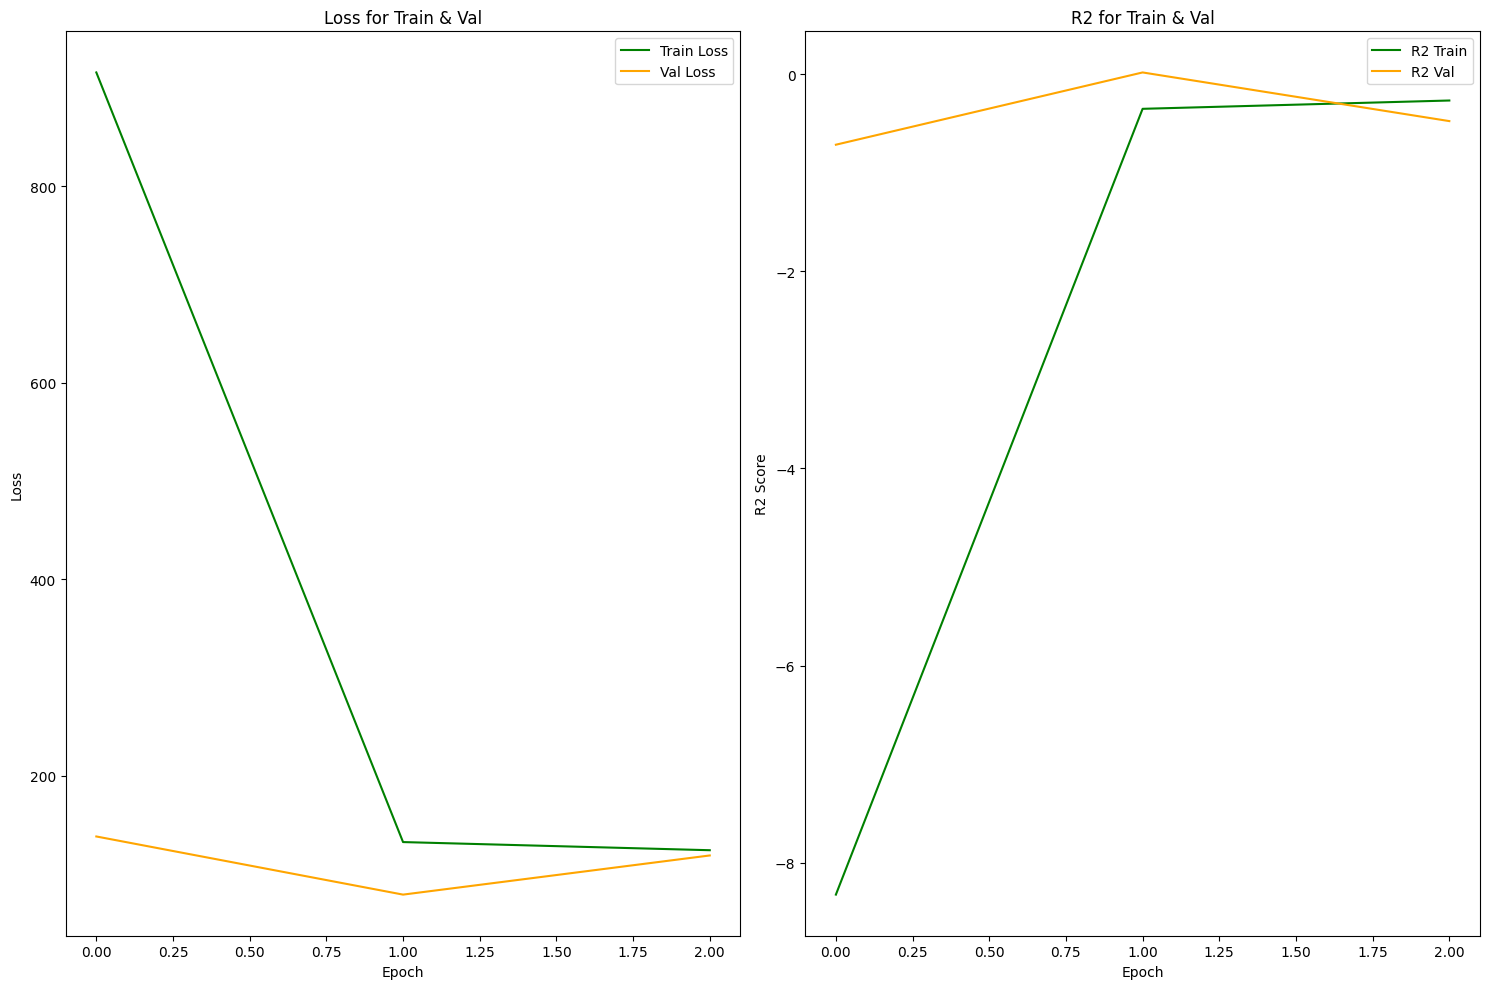

In [227]:
fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].plot(train_lossess, color='green', label = 'Train Loss')
ax[0].plot(val_lossess, color='orange', label = 'Val Loss')
ax[0].set(xlabel='Epoch', ylabel='Loss')
ax[0].set_title('Loss for Train & Val')
ax[0].legend()

ax[1].plot(metric_dict_train_collect["R2 Score"], color='green', label = 'R2 Train')
ax[1].plot(metric_dict_val_collect["R2 Score"], color='orange', label = 'R2 Val')
ax[1].set(xlabel='Epoch', ylabel='R2 Score')
ax[1].set_title('R2 for Train & Val')
ax[1].legend()

plt.tight_layout()

plt.show()

In [228]:
training.test()

Test session - Test Loss: 106.23195442607083 - R2 Score: -0.684643154754069
